In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline
plt.style.use('ggplot')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import GradientBoostingRegressor

In [266]:
data = pd.read_csv('data/OnlineNewsPopularity.csv')

In [267]:
y = data[' shares'].values
X = data.drop([' shares','url',' timedelta'], axis = 1).values

In [268]:
parameters = {
    'n_estimators':[1000],
    'max_features':['sqrt','log2',None], 'max_depth':[2,3,4,5],
    'min_samples_split':[.1,.5],'min_samples_leaf':[1,2,5],
}

rfr = RandomForestRegressor()
grid_search1 = GridSearchCV(rfr, param_grid=parameters, 
                            scoring = 'neg_mean_squared_error',
                            n_jobs = -1, cv = 10, verbose = 2)
grid_search1.fit(X,y)

In [270]:
grid_search1.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 0.1,
 'n_estimators': 1000}

In [190]:
def get_tree_oob_score(tree,X_train,y_train):
    #gets the oob score for the given tree
    indicies = _generate_unsampled_indices(tree.random_state, X_train.shape[0])
    y_true = y_train[indicies]
    y_hat_tree = tree.predict(X_train[indicies])
    rmse = np.sqrt(np.mean((y_true - y_hat_tree)**2))
    return rmse

def get_score_with_x_trees(x,predictions, y_val):
    #gets the RMSE for the top x trees in the list 
    predictions = predictions[:x]
    y_hat = predictions.mean(axis = 0)
    rmse = np.sqrt(np.mean((y_val - y_hat)**2))
    return rmse


In [293]:
def get_scores_n_fold(X,y,n_folds,parameters):
    
    kf = KFold(n_folds,shuffle=True)

    forest = RandomForestRegressor(n_estimators= parameters['n_estimators'], max_depth= parameters['max_depth'],
                                   n_jobs= -1, oob_score= True, max_features = parameters['max_features'],
                                   bootstrap= True, min_samples_leaf= parameters['min_samples_leaf'],
                                   min_samples_split = parameters['min_samples_split'])
    
    results = []
    for train_ind, test_ind in kf.split(X):
        X_train, X_test, y_train, y_test = X[train_ind], X[test_ind], y[train_ind], y[test_ind]
        forest.fit(X_train,y_train)
        
        y_test_hat = forest.predict(X_test)

        #rmse of the entire model
        full_model_rmse = np.sqrt( np.mean( ((y_test - y_test_hat)**2)  ) )

        trees = forest.estimators_
        n_trees = len(trees)
        #the oob scores used to evaluate the trees 
        oob_scores = [get_tree_oob_score(tree,X_train,y_train) for tree in trees]


        #trees ordered by their oob scores
        tree_inds = np.argsort(oob_scores)
        ordered_trees = [trees[i] for i in tree_inds]
        ordered_tree_preds = np.array([tree.predict(X_test) for tree in ordered_trees])    

        #trees randomly ordered
        random_tree_preds = np.array([tree.predict(X_test) for tree in trees])
        #this gets the score for the best x trees for x from 1 to 1000   
        scores = []
        for x in range(1,n_trees+1):
            scores.append(get_score_with_x_trees(x,ordered_tree_preds,y_test))
        #this gets the score for a random x trees from 1 to 1000 as a null hypothesis
        random_scores = []
        for x in range(1,n_trees+1):
            random_scores.append(get_score_with_x_trees(x,random_tree_preds,y_test))
            
        results.append((full_model_rmse,scores,random_scores))
    
    return results

In [291]:
def run_experiment(X,y,num_models,n_folds,parameters):
    results = []
    t1 = time.time()
    for x in range(0,num_models):
        results.extend(get_scores_n_fold(X,y,10, parameters))
        if (x == num_models/2) or (x == 0):
            print("{}/{} done in {} seconds".format((x+1)*n_folds,num_models*n_folds, time.time() - t1))
    return results

In [285]:
def plot_results(results_list,n_trees, xlims, ylims,gberrors = [], relative = True):
    """Plots the results from results_list in 3 different columns if ylims are the same it uses auto y limits"""
    fig, axs = plt.subplots(ncols=len(results_list), nrows = 4, figsize = (10*len(results_list),30))
    
    #plots the difference in error between each forest as you add trees from 1 to n_trees and the full n_trees tree model
    #both randomly and in order of oob score
    
    #this loops over sets of results to compare across hyperparameters
    for i,results in enumerate(results_list):
        #loops across models with different train test splits
        for total, scores, random_scores in results:
            if not relative:
                total = 0
            axs[0][i].plot([x for x in range(1,n_trees+ 1)], [s - total  for s in scores], 'b', alpha = 0.1)
            axs[1][i].plot([x for x in range(1,n_trees+ 1)], [s - total  for s in random_scores], 'r', alpha = 0.1)
            axs[2][i].plot([x for x in range(1,n_trees+1)], [s-r for s,r in zip(scores,random_scores)],'m',alpha = 0.1)
            
            if relative: 
                axs[0][i].hlines(0,0,1000,color = 'g',alpha = .8)
                axs[1][i].hlines(0,0,1000,color = 'g',alpha = .8)
                axs[2][i].hlines(0,0,1000,color = 'g',alpha = .8)

    #plots the average difference between the forests with x trees and the full 1000 tree model
        average_ordered, average_random, average_diff = [],[],[]   
        for x in range(0,n_trees):
            ordered,rand,diff = [],[],[]
            for total,o_scores,r_scores in results:
                if not relative: 
                    total = 0
                ordered.append(o_scores[x] - total)
                rand.append(r_scores[x] - total)
                diff.append(o_scores[x] - r_scores[x])
            average_diff.append(np.mean(diff))
            average_ordered.append(np.mean(ordered))
            average_random.append(np.mean(rand))
        axs[0][i].plot([x for x in range(1,n_trees+ 1)],average_ordered,'b',alpha = .8)        
        axs[1][i].plot([x for x in range(1,n_trees+ 1)],average_random, 'r', alpha = 0.8)
        axs[2][i].plot([x for x in range(1,n_trees+ 1)],average_diff, 'm', alpha = 0.8)
        
        axs[3][i].plot([x for x in range(1,n_trees+ 1)],average_ordered,'b',alpha = .8)                
        axs[3][i].plot([x for x in range(1,n_trees+ 1)],average_random, 'r', alpha = 0.8)
        total_average = 0
        if not relative: 
            total_average = np.mean([r[0] for r in results])
            ylims = ylims[0]+total_average, ylims[1]+total_average
        axs[3][i].hlines(total_average,0,n_trees,color = 'g',alpha = .8)

        #compares to some gradient boosted models (or any errors) if provided
        if gberrors:
            total_average = np.mean([r[0] for r in results])
            if not relative: total_average = 0
            for gbe in gberrors:
                axs[2].hlines( gbe - total_average ,0,n_trees,color='m',alpha = .3)
            axs[2].hlines(np.mean(gberrors),0,n_trees,color='m',alpha = .8)
        #sets the axis limits
        if ylims[0] != ylims[1]:
            axs[0][i].set_ylim(ylims[0],ylims[1])
            axs[1][i].set_ylim(ylims[0],ylims[1])    
            axs[3][i].set_ylim(ylims[0],ylims[1])   
    
        axs[0][i].set_xlim(xlims[0],xlims[1])
        axs[1][i].set_xlim(xlims[0],xlims[1])
        axs[2][i].set_xlim(xlims[0],xlims[1])
        axs[3][i].set_xlim(xlims[0],xlims[1])

    plt.show()
    return axs

In [228]:
def train_gradient_boosters(n,X,y,n_estimators = 1000):
    #trains a bunch of gradient boosting classifiers 
    errors = []
    for i in range(0,n):
        gbr = GradientBoostingRegressor(n_estimators=n_estimators,learning_rate=.001,max_depth=3,subsample=.5,max_features = None)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        gbr.fit(X_train,y_train)
        y_hat = gbr.predict(X_test)
        rmse = np.sqrt( np.mean( (y_test - y_hat)**2))
        errors.append(rmse)
    return errors

In [272]:
features = [None, 'sqrt', 'log2']
results = [run_experiment(5,X,y,10,500,f) for f in features]   

10/50 done in 632.0107593536377 seconds
10/50 done in 126.33247828483582 seconds
10/50 done in 106.40521216392517 seconds


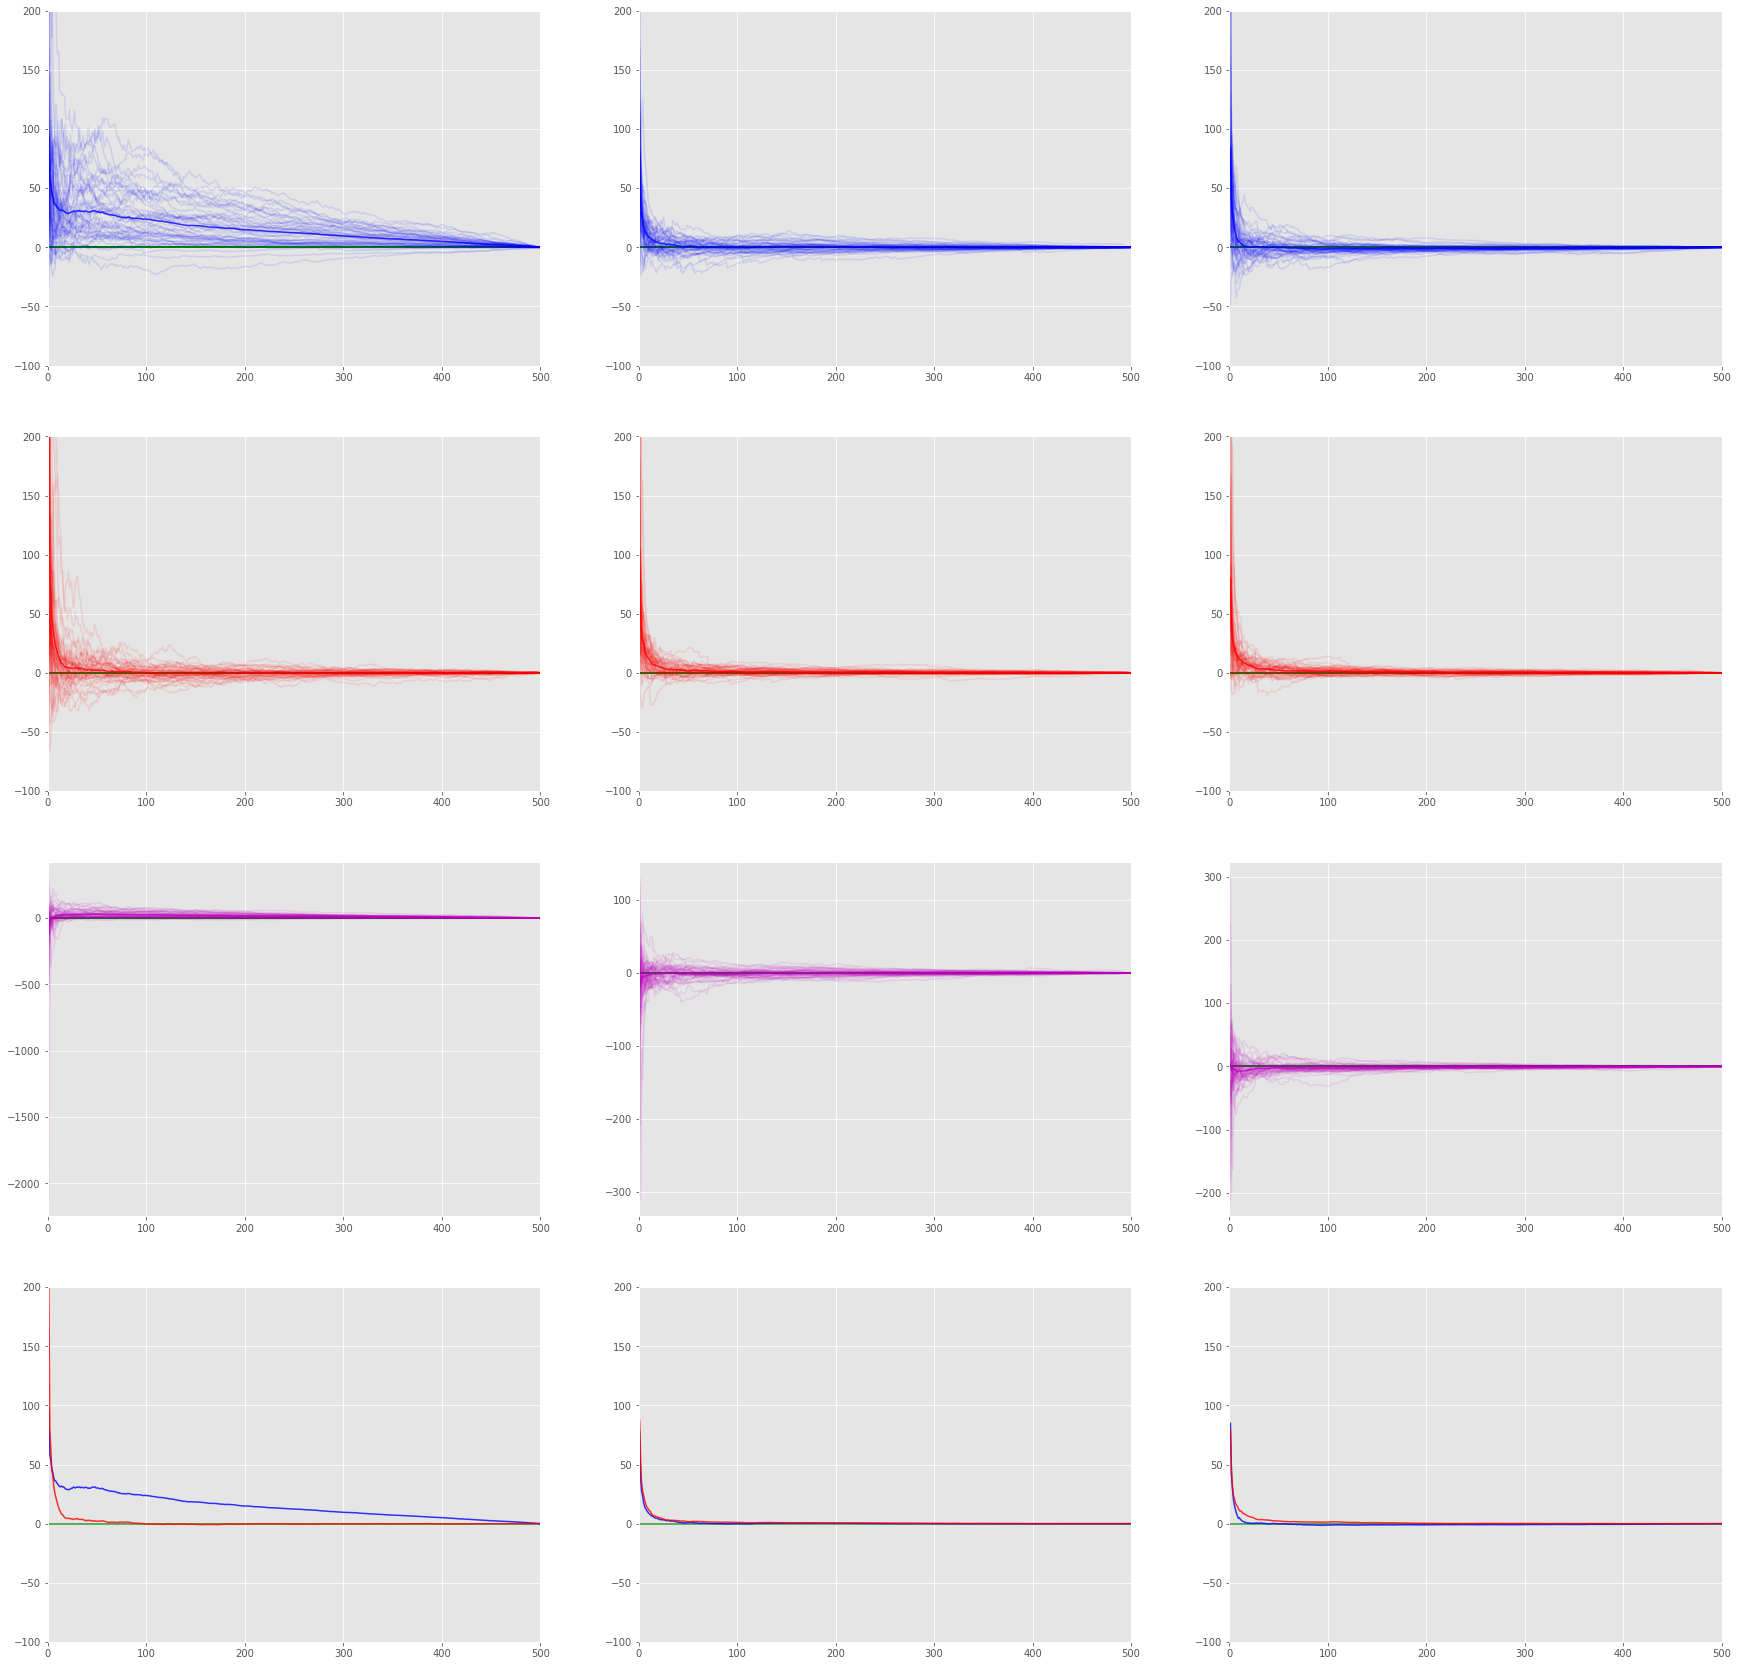

In [275]:
axs1 = plot_results(results,500,(0,500),(-100,200))

In [4]:
data2 = pd.read_csv('data/slump_test.data.csv',index_col='No')

In [176]:
X2,y2 = data2.drop('Compressive Strength (28-day)(Mpa)', axis = 1).values,data2['Compressive Strength (28-day)(Mpa)'].values

In [278]:
parameters = {
    'n_estimators':[1000],
    'max_features':['sqrt','log2',None], 'max_depth':[2,3,4,5],
    'min_samples_split':[.1,.5],'min_samples_leaf':[1,2,5],
}

rfr = RandomForestRegressor()
grid_search2 = GridSearchCV(rfr, param_grid=parameters, 
                            scoring = 'neg_mean_squared_error',
                            n_jobs = -1, cv = 10, verbose = 1)
grid_search2.fit(X2,y2)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000, total=   1.3s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000, total=   1.4s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000, total=   1.7s
[

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.6s


[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.7s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.7s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.8s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.8s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.6s
[CV] max_depth=2, max_features=sqr

[CV] max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000, total=   1.7s
[CV] max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000, total=   1.8s
[CV]  max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000 
[CV] max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=log2, min_samples

[CV]  max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.7s
[CV] max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.3s
[CV] max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.6s
[CV] max_depth=2, max_features=log

[CV] max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.1, n_estimators=1000, total=   1.7s
[CV] max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.4s
[CV] max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.7s
[CV] max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=None, min_samples

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min


[CV]  max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.4s
[CV] max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=2, max_features=Non

[CV] max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000, total=   1.6s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000, total=   1.6s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000, total=   1.8s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=3, max_features=sqrt, min_samples

[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.6s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.6s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=3, max_features=sqr

[CV] max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.6s
[CV] max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=log2, min_samples

[CV]  max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000, total=   1.7s
[CV] max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000, total=   1.8s
[CV] max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000, total=   1.8s
[CV] max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=3, max_features=Non

[CV] max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000, total=   1.8s
[CV] max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000, total=   1.7s
[CV] max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000, total=   1.7s
[CV] max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.4s
[CV] max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=3, max_features=None, min_samples

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.5min


[CV]  max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.7s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.4s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000, total=   1.5s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000, total=   1.6s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000, total=   1.7s
[CV] max_depth=4, max_features=sqr

[CV] max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.6s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.6s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000, total=   1.8s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=4, max_features=sqrt, min_samples

[CV]  max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000, total=   1.6s
[CV] max_depth=4, max_features=log

[CV] max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.7s
[CV] max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.6s
[CV] max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.6s
[CV] max_depth=4, max_features=None, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=4, max_features=None, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=4, max_features=log2, min_samples

[CV]  max_depth=4, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.4s
[CV] max_depth=4, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=4, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.4s
[CV] max_depth=4, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=4, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=4, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=4, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.4s
[CV] max_depth=4, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=4, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=4, max_features=Non

[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000, total=   1.7s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000, total=   1.6s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=5, max_features=sqrt, min_samples

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000, total=   2.7s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   2.8s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   2.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   2.4s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   2.2s
[CV] max_depth=5, max_features=sqr

[CV] max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=0.1, n_estimators=1000, total=   1.3s
[CV] max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=0.1, n_estimators=1000, total=   1.4s
[CV] max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.3s
[CV] max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.3s
[CV] max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=5, max_features=log2, min_samples

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.7min


[CV]  max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000, total=   1.4s
[CV] max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000, total=   1.5s
[CV] max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000, total=   1.4s
[CV] max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000, total=   1.4s
[CV] max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000, total=   1.5s
[CV] max_depth=5, max_features=log

[CV] max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=0.5, n_estimators=1000, total=   1.7s
[CV] max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=0.1, n_estimators=1000, total=   1.5s
[CV] max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=0.1, n_estimators=1000, total=   1.6s
[CV] max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=0.1, n_estimators=1000, total=   1.7s
[CV] max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=5, max_features=None, min_samples

[CV]  max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.3s
[CV]  max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   0.9s


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  5.2min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1000], 'max_features': ['sqrt', 'log2', None], 'max_depth': [2, 3, 4, 5], 'min_samples_split': [0.1, 0.5], 'min_samples_leaf': [1, 2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [286]:
params2 = grid_search2.best_params_
print(params2)

{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 0.1, 'n_estimators': 1000}


In [306]:
params2a = params2
params2a['max_features'],params2['max_features'] = 'sqrt',None
results2  = [run_experiment(X2,y2,10,10,params2),run_experiment(X2,y2,10,10,params2a)]

10/100 done in 12.740002155303955 seconds
60/100 done in 78.77094292640686 seconds
10/100 done in 12.477766036987305 seconds
60/100 done in 71.9592137336731 seconds


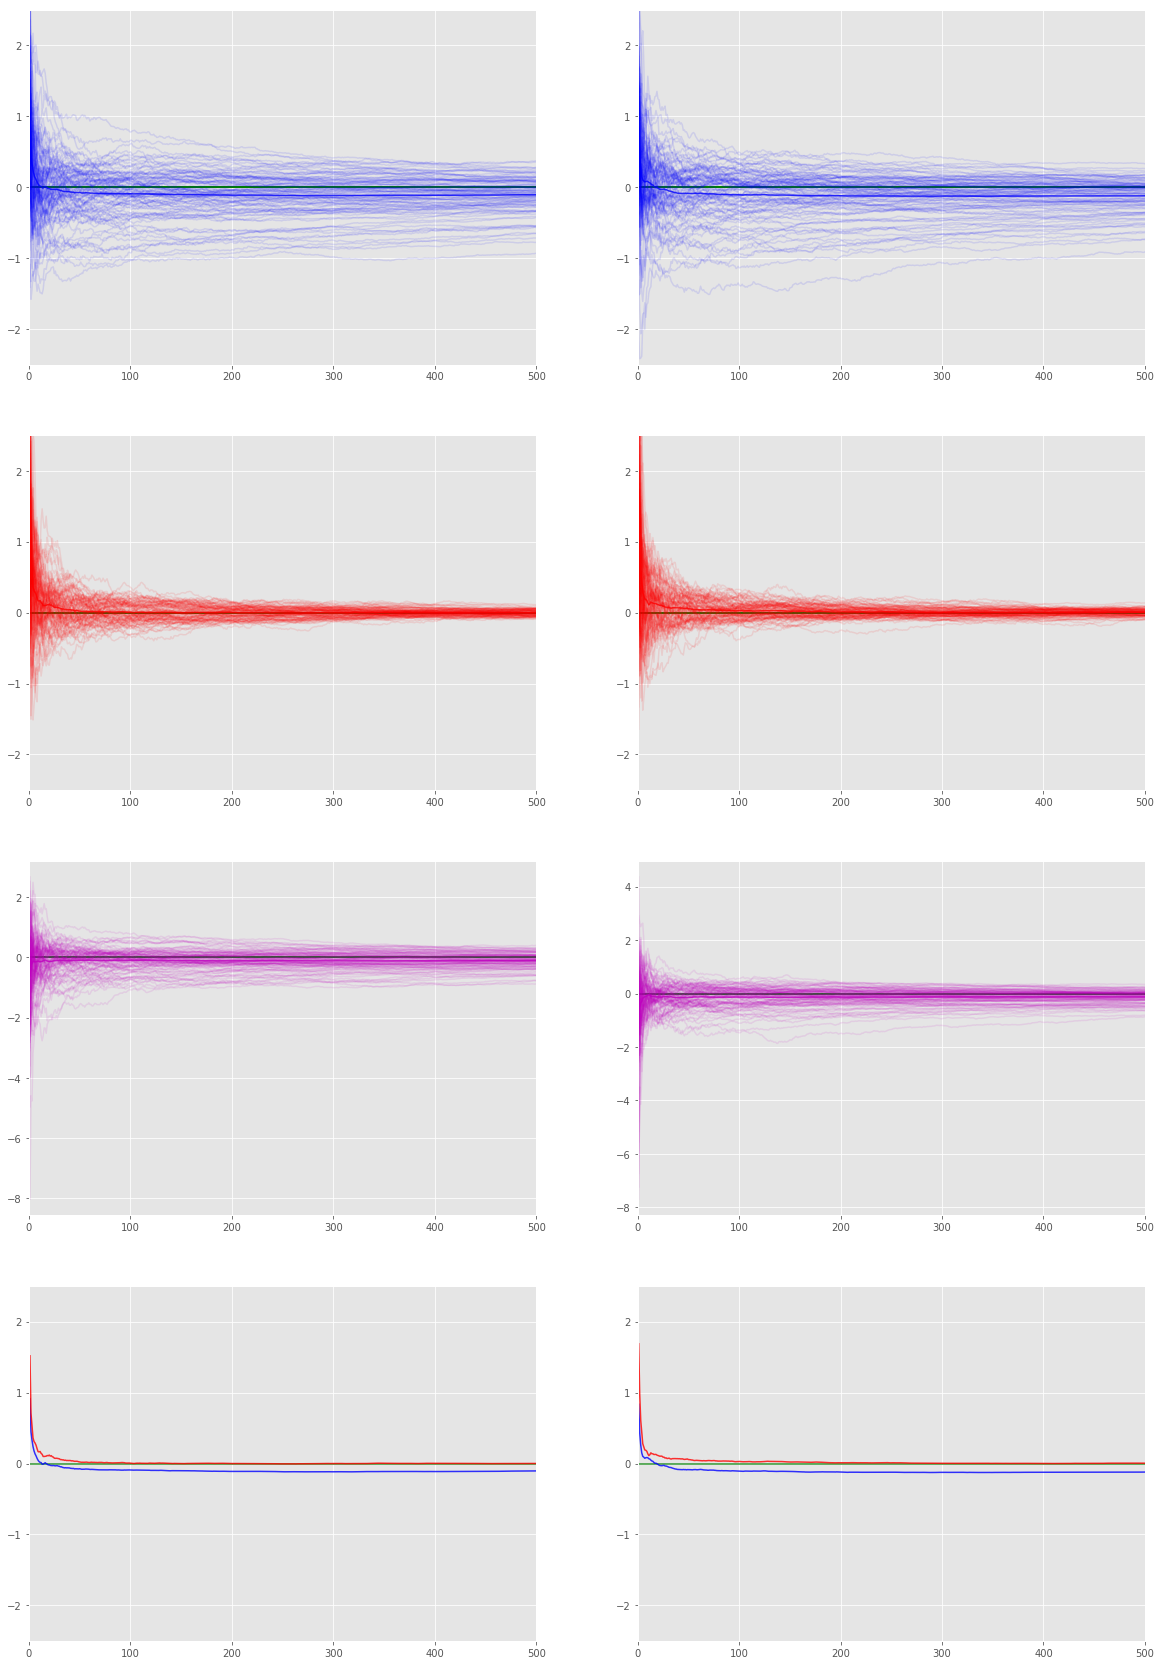

In [307]:
axs2 = plot_results(results2,1000,(0,500),(-2.5,2.5))

In [98]:
gberrors2 = train_gradient_boosters(10,X2,y2)

In [81]:
# this data has only categorical variables so we can see that effect
data3 = pd.read_csv('data/flare.data2.csv',header=None, delimiter = ' ')

In [ ]:
rdzdata3.head(3)

In [83]:
X3 = pd.get_dummies(data3,columns=[0,1,2,3,4,5,6,7,8,9]).drop([10,11,12], axis = 1).values
y3 = data3[10].values

In [233]:
features = [None,'sqrt','log2']
results3 = [run_experiment(10,X3,y3,10,500,f) for f in features]


10/100 done in 7.726862192153931 seconds
60/100 done in 48.718539237976074 seconds
10/100 done in 8.53221321105957 seconds
60/100 done in 48.28748321533203 seconds
10/100 done in 7.796365737915039 seconds
60/100 done in 46.72277498245239 seconds


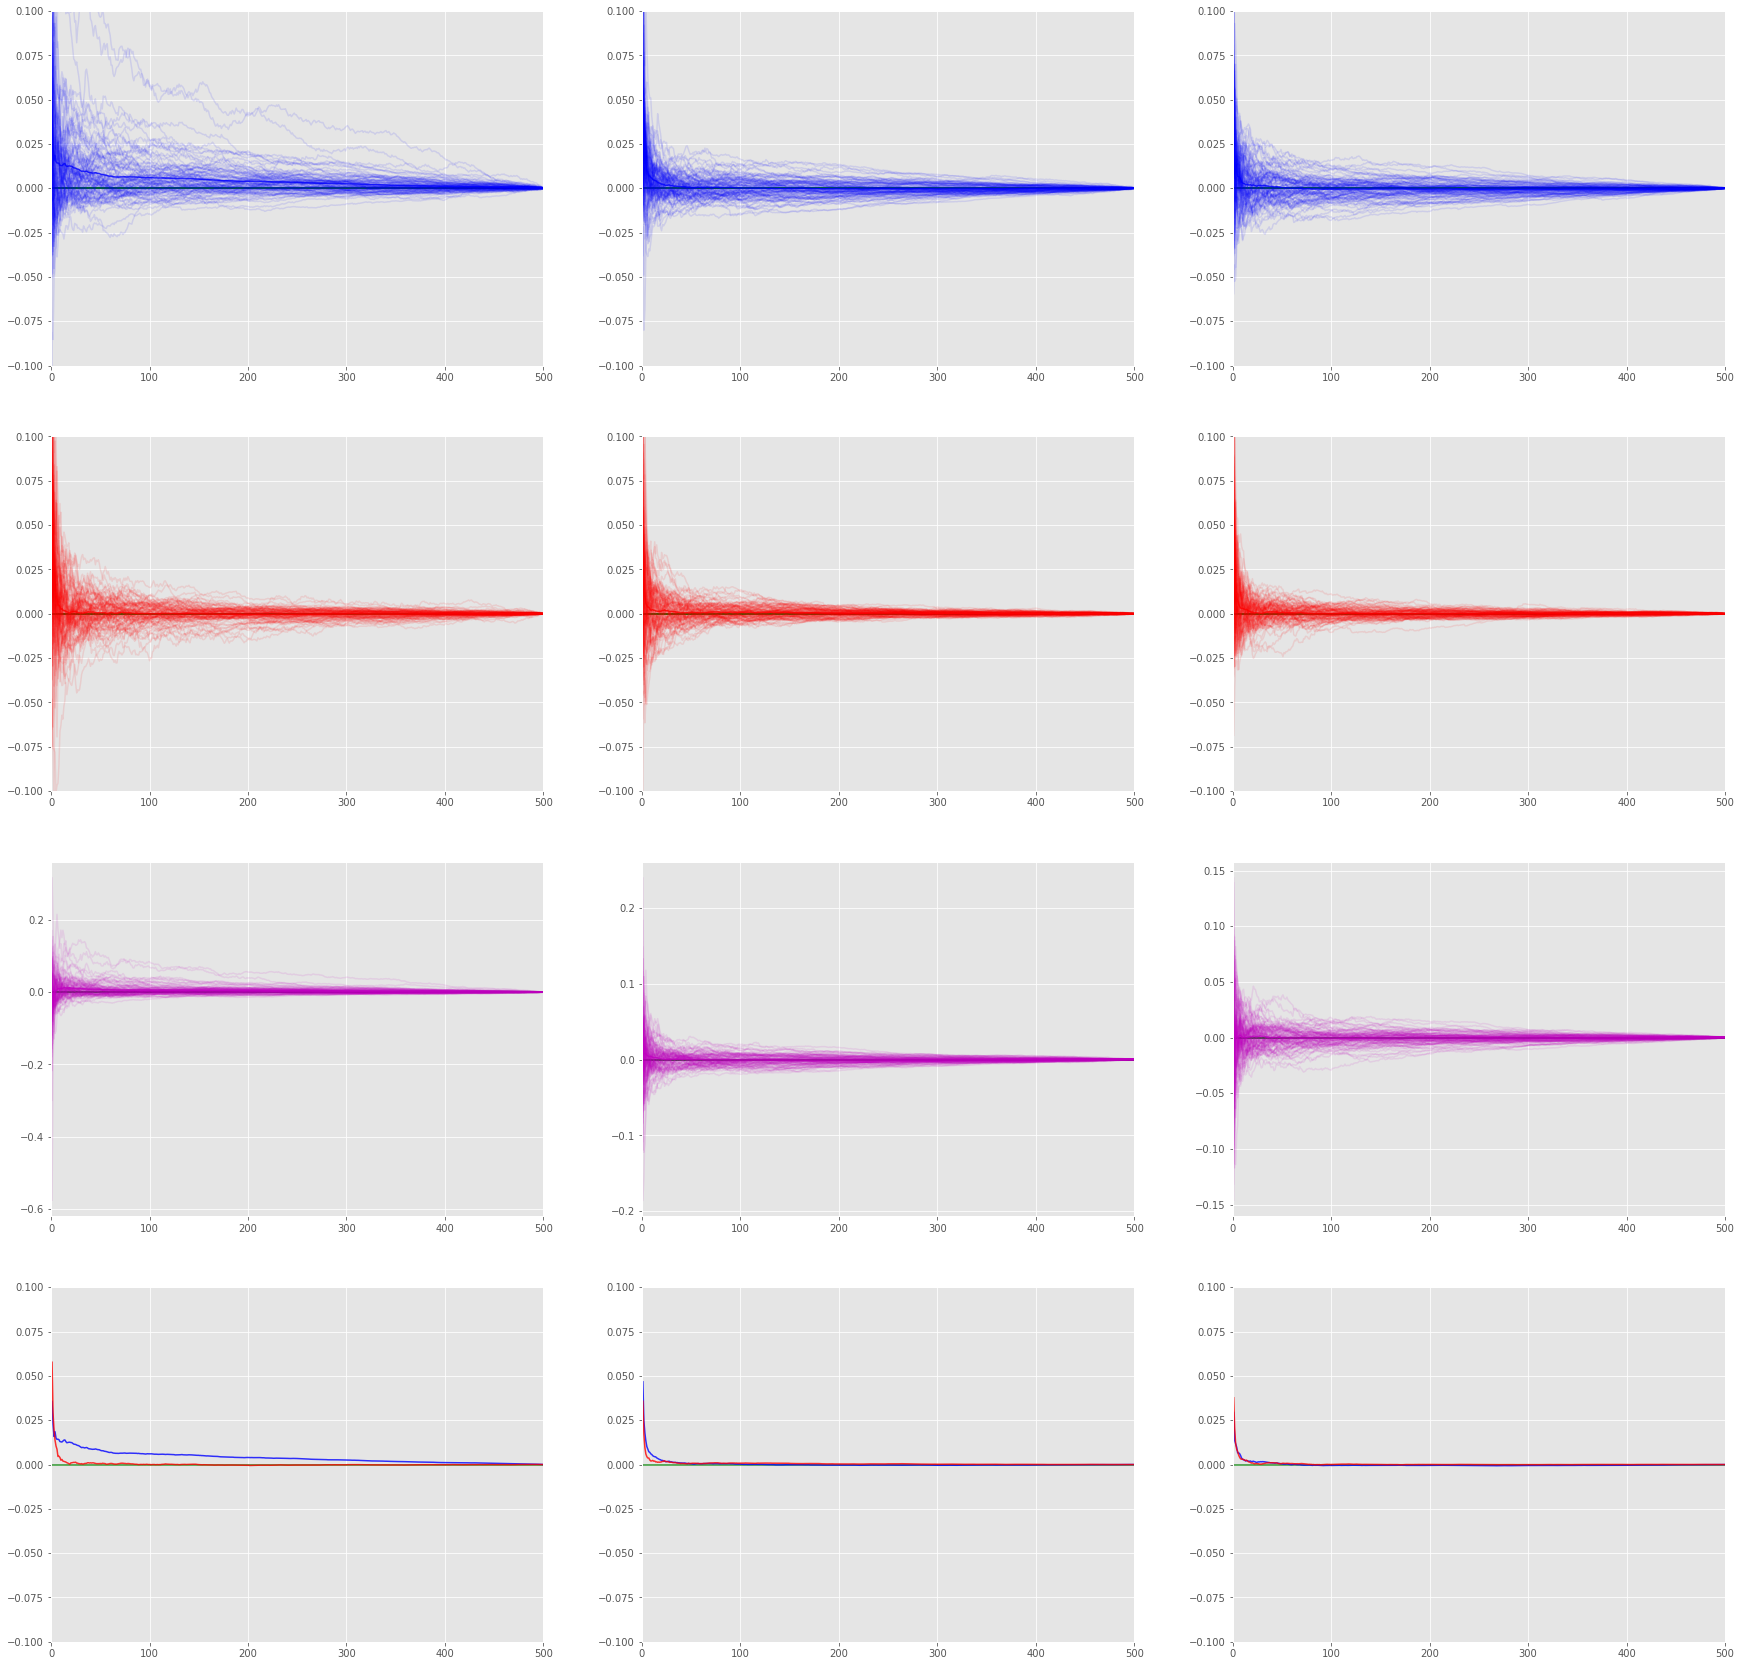

In [242]:
plot_results(results3,500,(0,500),(-.1,.1),)

In [145]:
data4 = pd.read_csv("data/student-mat.csv",delimiter = ";")

In [151]:
X4 = pd.get_dummies(data4,columns = ['school','sex','address','famsize','Pstatus','Medu',
                    'Fedu','Mjob','Fjob','reason','guardian','traveltime',
                    'studytime','failures','schoolsup','famsup','paid','activities',
                    'activities','nursery','higher','internet','romantic']).drop(['G1','G2','G3'],axis = 1).values
y4 = data4['G3'].values

In [244]:
features = [None,'sqrt','log2']
results4 = [run_experiment(10,X4,y4,10,500,f) for f in features]

10/100 done in 8.430346488952637 seconds
60/100 done in 48.492730379104614 seconds
10/100 done in 7.842536449432373 seconds
60/100 done in 47.473854541778564 seconds
10/100 done in 7.970993518829346 seconds
60/100 done in 48.33489680290222 seconds


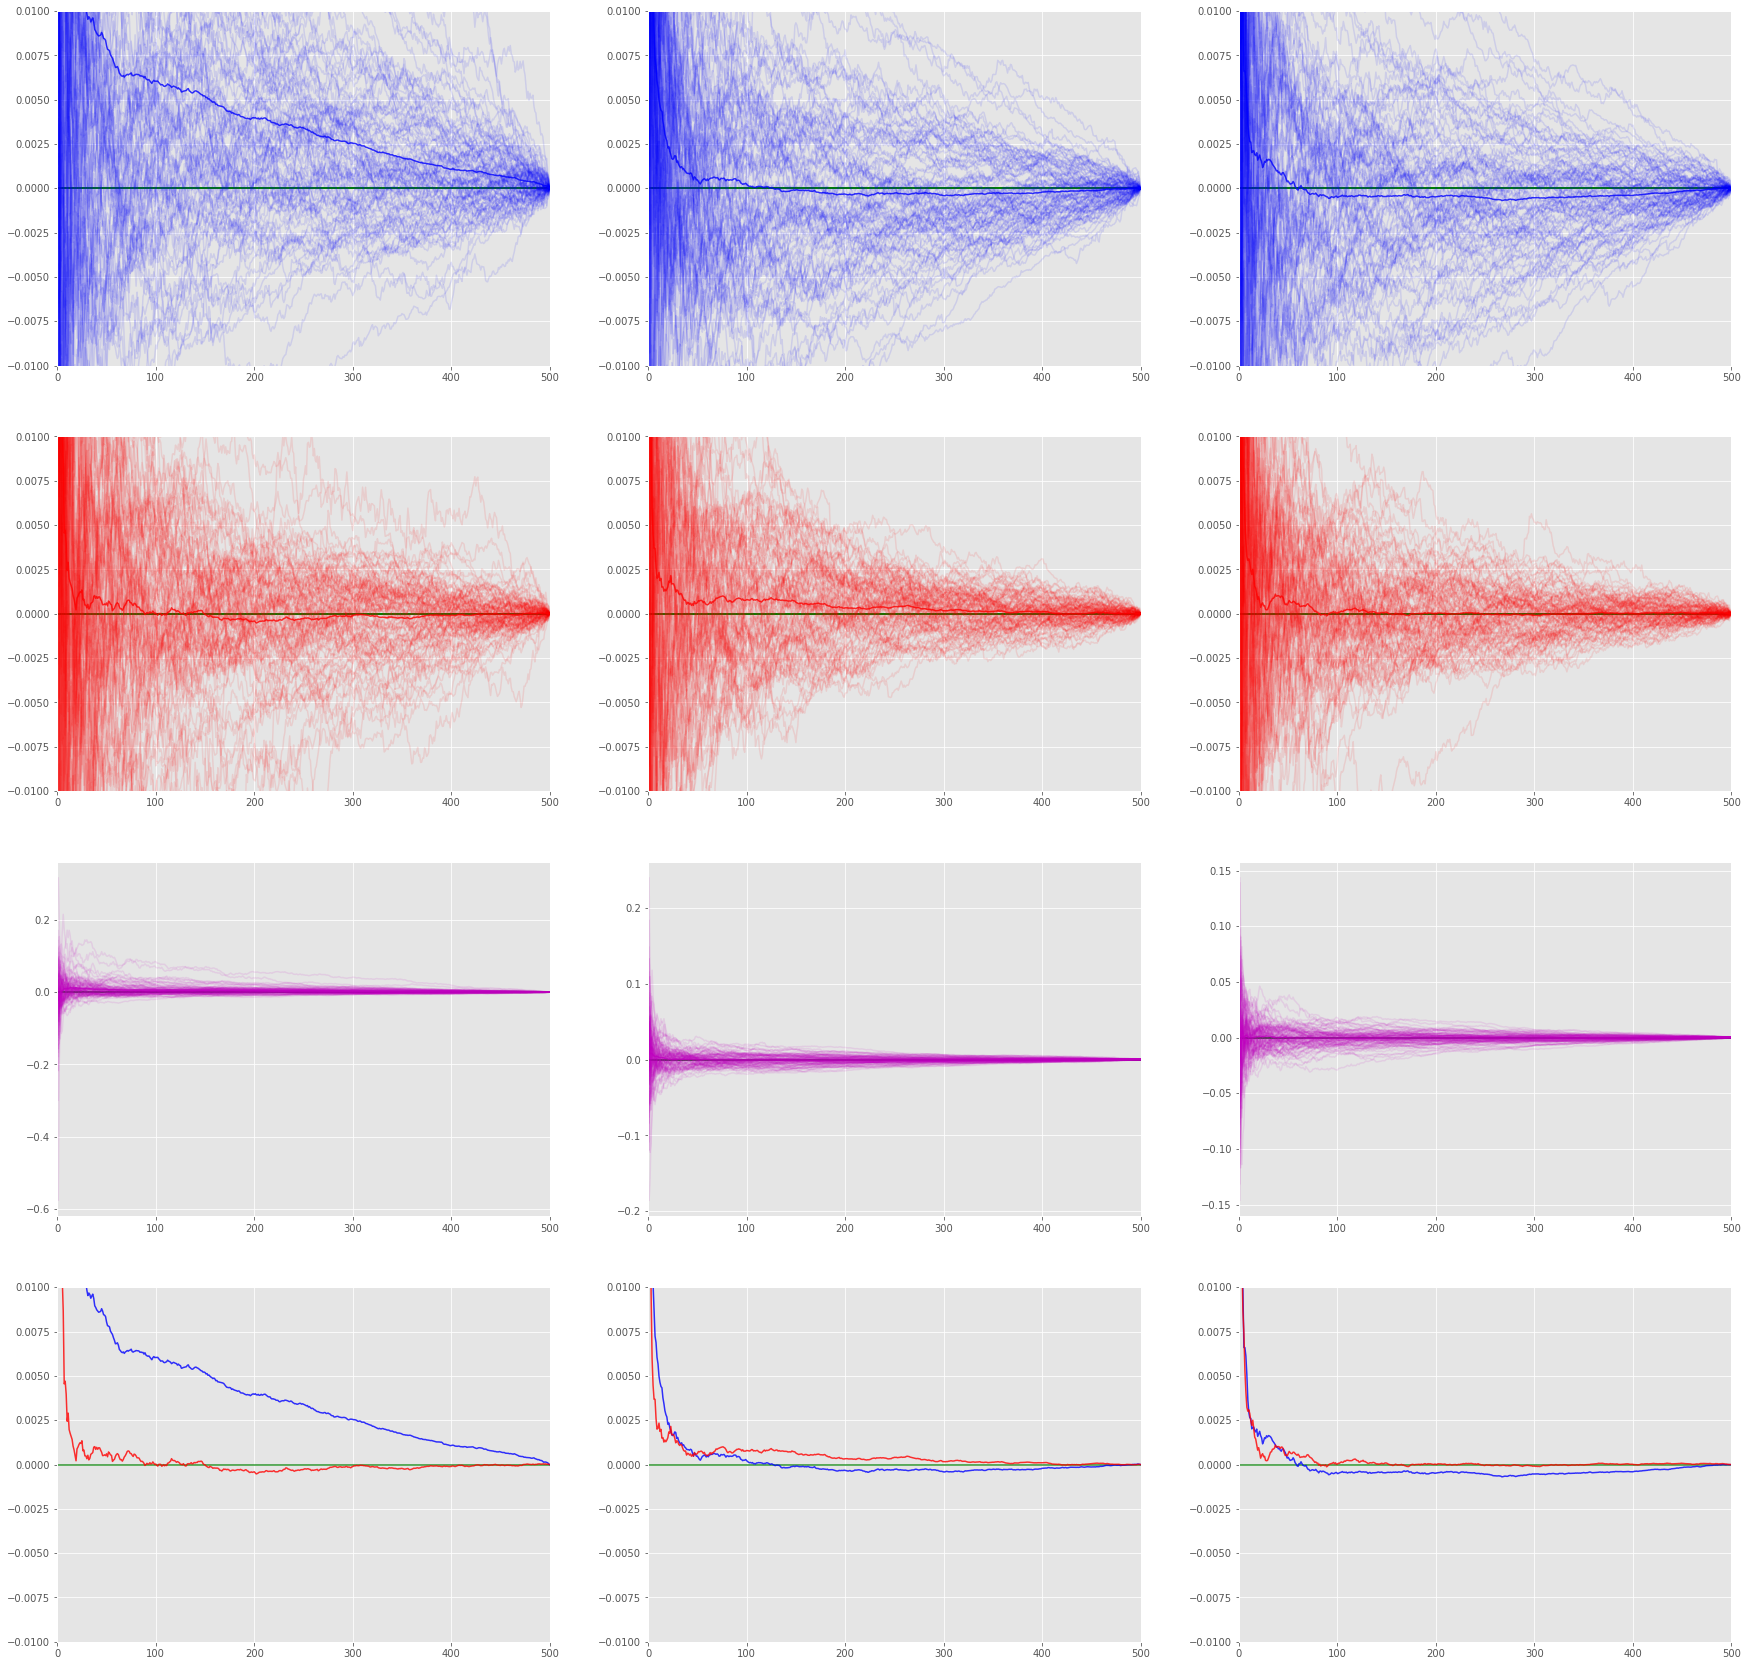

In [247]:
plot_results(results3,500,(0,500),(-.01,.01))

In [34]:
min_ordereds, min_randoms, compared_ordered, compared_random = [],[],[],[]
for total, scores, random_scores in results:
    min_scores = np.argmin(scores)
    min_ordereds.append(min_scores)
    compared = total - min(scores)
    compared_ordered.append(compared)
    min_random = np.argmin(random_scores)
    min_randoms.append(min_random)
    compared= total - min(random_scores)
    compared_random.append(compared)